In [1]:
import pandas as pd

df = pd.read_csv("../data/cleaned/cleaned_brentoil_data.csv", parse_dates=['Date'], index_col='Date')
df.dropna(inplace=True)

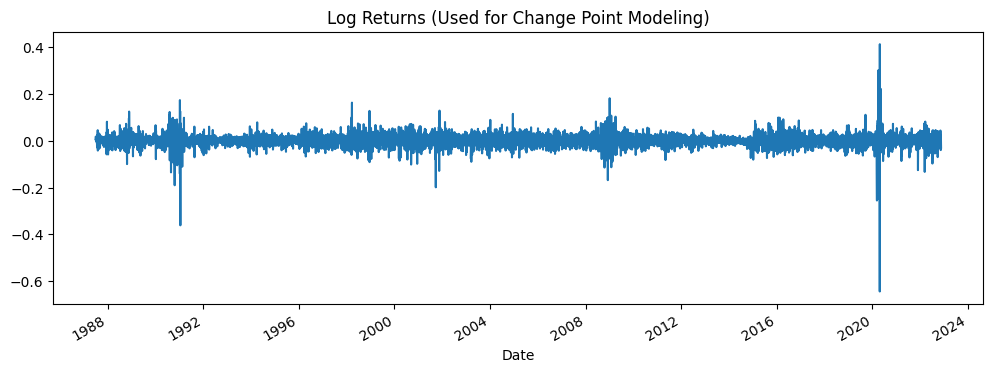

In [2]:
import matplotlib.pyplot as plt

df['log_return'].plot(figsize=(12, 4), title="Log Returns (Used for Change Point Modeling)")
plt.show()

In [3]:
import pymc as pm
import numpy as np
import arviz as az

# Limit dataset for faster sampling
returns = df['log_return'].dropna().iloc[:200].values
n = len(returns)
idx = np.arange(n)

with pm.Model() as model_cp:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    mu1 = pm.Normal('mu1', mu=0, sigma=0.05)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.05)
    sigma = pm.HalfNormal('sigma', sigma=0.05)

    mu = pm.math.switch(tau >= idx, mu1, mu2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    trace = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


c:\PY\Change-point-analysis-and-statistical-modelling-of-time-series-data\venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 684 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,116.274,74.718,0.000,196.000,21.657,3.561,14.0,33.0,1.20
mu1,0.001,0.006,-0.006,0.011,0.001,0.001,72.0,298.0,1.07
mu2,0.004,0.013,-0.005,0.020,0.001,0.005,37.0,213.0,1.08
sigma,0.018,0.001,0.017,0.020,0.000,0.000,1614.0,1661.0,1.00


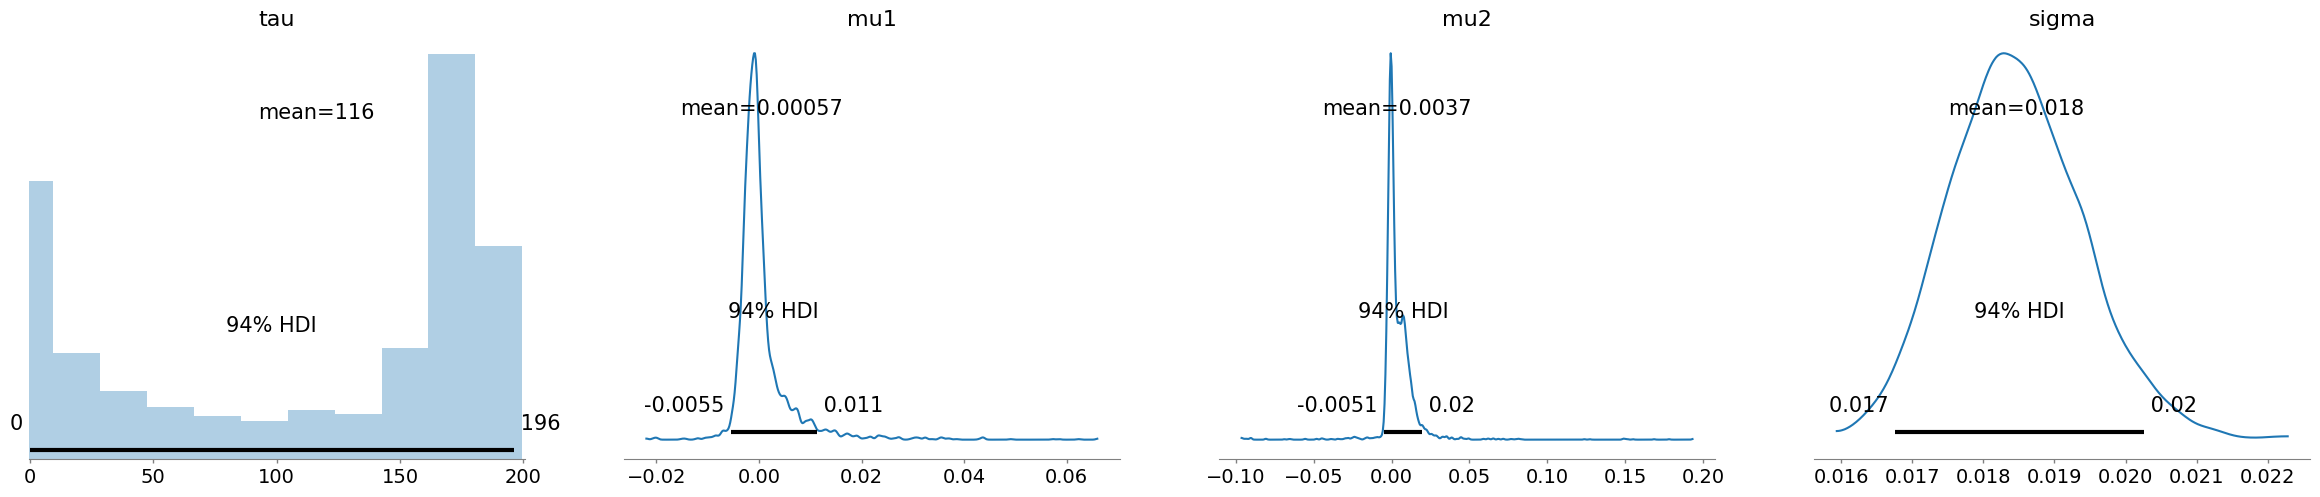

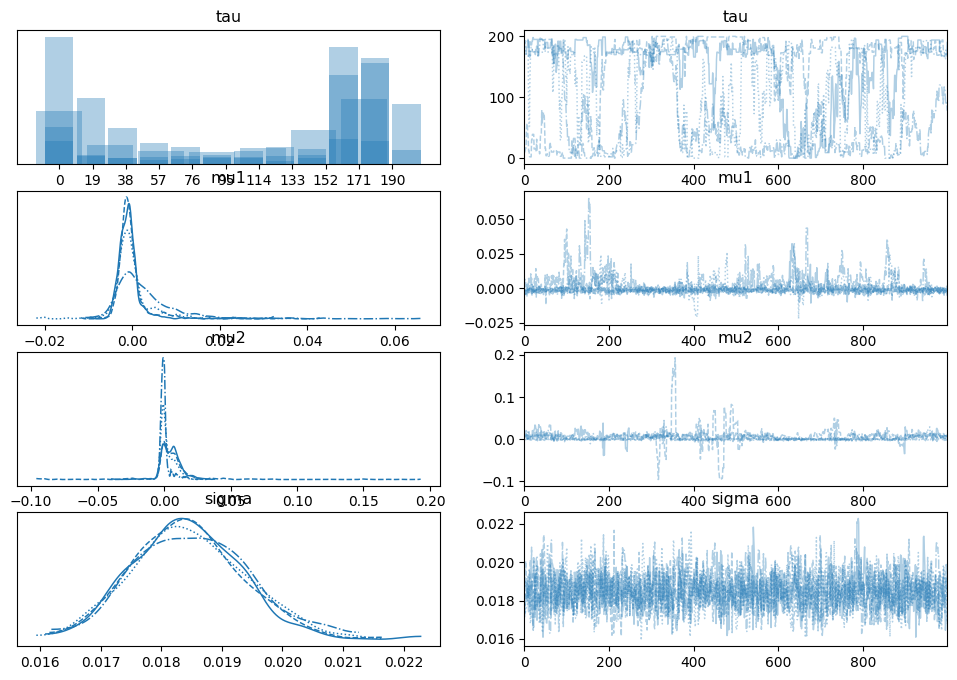

In [4]:
#convergence
import arviz as az

# Posterior plot
az.plot_posterior(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

# Trace plot
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

# Summary stats
az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

In [5]:
#most probable change point 
tau_posterior = trace.posterior['tau'].values.flatten()
tau_mode = np.bincount(tau_posterior).argmax()
print(f"Most probable change point index: {tau_mode}")
print(f"Corresponding date: {df.index[tau_mode]}")


Most probable change point index: 174
Corresponding date: 1988-03-08 00:00:00


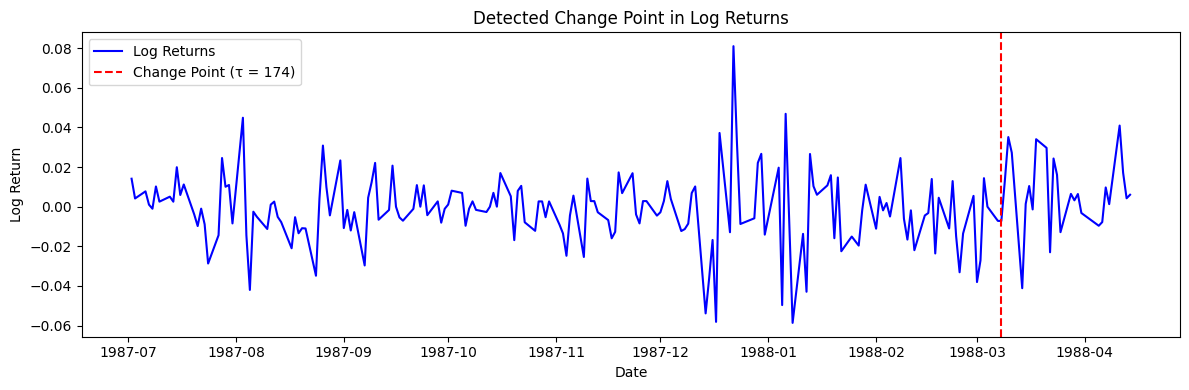

In [7]:
# Plot the log returns with change point
plt.figure(figsize=(12, 4))
plt.plot(df.index[:len(returns)], returns, label='Log Returns', color='blue')
plt.axvline(df.index[tau_mode], color='red', linestyle='--', label=f'Change Point (τ = {tau_mode})')
plt.title("Detected Change Point in Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
#Report the posterior means of mu1 and mu2
mu1_mean = trace.posterior['mu1'].mean().values
mu2_mean = trace.posterior['mu2'].mean().values

print(f"Mean before change: {mu1_mean:.5f}")
print(f"Mean after change: {mu2_mean:.5f}")
print(f"Percent Change: {(mu2_mean - mu1_mean)/abs(mu1_mean) * 100:.2f}%")


Mean before change: 0.00057
Mean after change: 0.00370
Percent Change: 550.39%
